In [1]:
!gdown 18eSV0_cyNXxGrHC1PqLczZLVgmqF6Ipg
!gdown 14ia73lmckmrb_Ag_rC5ZaTr7EnfyB1zR

Downloading...
From: https://drive.google.com/uc?id=18eSV0_cyNXxGrHC1PqLczZLVgmqF6Ipg
To: /content/protonspeed.csv
100% 92.9k/92.9k [00:00<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=14ia73lmckmrb_Ag_rC5ZaTr7EnfyB1zR
To: /content/field.csv
100% 74.3k/74.3k [00:00<00:00, 81.2MB/s]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
speed = pd.read_csv('protonspeed.csv')
field = pd.read_csv('field.csv')

In [4]:
sp = np.array(speed['ProtonSpeed (km/s)'])
fld = np.array(field['Field (nT)'])
sp = sp[:len(fld)]

In [5]:
for i in range(len(sp)):
  if sp[i] > 1000:
    sp[i] = 1000

In [6]:
time_step = [i for i in range(len(sp))]

In [7]:
split_time = 6500

# Get the train set 
time_train = time_step[:split_time]
sp_train = sp[:split_time]
fld_train = sp[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
sp_valid = sp[split_time:]
fld_valid = fld[split_time:]

In [8]:
df_train = pd.DataFrame(columns=['speed', 'field'])

In [9]:
df_train['speed'] = sp_train
df_train['field'] = fld_train

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_train) 

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
feature = data_scaled[:,1]
target = data_scaled[:,0]

In [38]:
win_length = 24
batch_size = 120
num_features = 1
train_generator = TimeseriesGenerator(feature, target, length=win_length, sampling_rate=1, batch_size=batch_size)

In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[win_length, num_features]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
])
Wsave = model.get_weights()
 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 24, 128)           98816     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 80)                10320     
                                                                 
 dense_1 (Dense)             (None, 20)                1620      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 242,617
Trainable params: 242,617
Non-trai

In [40]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
54/54 [==============================] - 3s 10ms/step - loss: 0.0446 - lr: 1.0000e-08
Epoch 2/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0446 - lr: 1.1220e-08
Epoch 3/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 1.2589e-08
Epoch 4/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 1.4125e-08
Epoch 5/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0445 - lr: 1.5849e-08
Epoch 6/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 1.7783e-08
Epoch 7/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 1.9953e-08
Epoch 8/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 2.2387e-08
Epoch 9/100
54/54 [==============================] - 0s 9ms/step - loss: 0.0445 - lr: 2.5119e-08
Epoch 10/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0445 - lr: 2.8184e-08
Epoch 11/100
54/54 [========

(1e-08, 0.001, 0.0, 1.0)

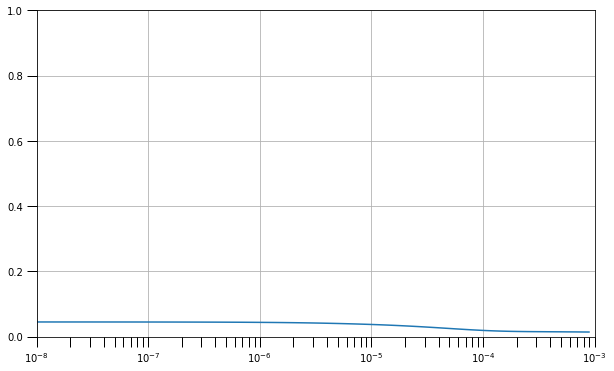

In [41]:
import matplotlib.pyplot as plt

lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])

In [42]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [43]:
tf.keras.backend.clear_session()
model.set_weights(Wsave)

learning_rate = 8.9125e-04

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [44]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(patience=50, monitor='mae', min_delta=0, mode='min', restore_best_weights=True),

In [45]:
history = model.fit(train_generator,epochs=250, callbacks=[callback])

Epoch 1/250
54/54 [==============================] - 3s 10ms/step - loss: 0.0288 - mae: 0.1615
Epoch 2/250
54/54 [==============================] - 0s 9ms/step - loss: 0.0162 - mae: 0.1054
Epoch 3/250
54/54 [==============================] - 0s 9ms/step - loss: 0.0149 - mae: 0.1055
Epoch 4/250
54/54 [==============================] - 1s 9ms/step - loss: 0.0146 - mae: 0.1067
Epoch 5/250
54/54 [==============================] - 1s 9ms/step - loss: 0.0144 - mae: 0.1068
Epoch 6/250
54/54 [==============================] - 0s 9ms/step - loss: 0.0143 - mae: 0.1070
Epoch 7/250
54/54 [==============================] - 1s 9ms/step - loss: 0.0140 - mae: 0.1046
Epoch 8/250
54/54 [==============================] - 0s 9ms/step - loss: 0.0139 - mae: 0.1037
Epoch 9/250
54/54 [==============================] - 1s 9ms/step - loss: 0.0137 - mae: 0.1034
Epoch 10/250
54/54 [==============================] - 1s 9ms/step - loss: 0.0135 - mae: 0.1016
Epoch 11/250
54/54 [==============================] - 1s 9

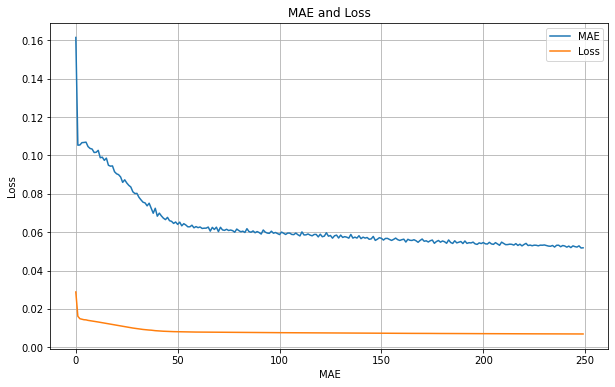

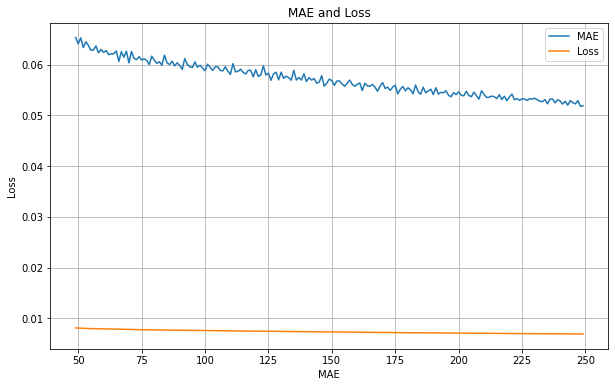

In [46]:
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [47]:
df_test = pd.DataFrame(columns=['speed', 'field'])
df_test['speed'] = sp_valid
df_test['field'] = fld_valid

In [48]:
data_scaled_test = scaler.fit_transform(df_test)

In [50]:
features_test = data_scaled_test
target_test = data_scaled_test[:,0]
win_length = 24
batch_size = 120
num_features = 1
test_generator = TimeseriesGenerator(features_test, target_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [51]:
predictions = model.predict(test_generator)

In [52]:
sc = MinMaxScaler()
sc = sc.fit(np.array(df_train['speed']).reshape(-1,1))
predictions = sc.inverse_transform(predictions)

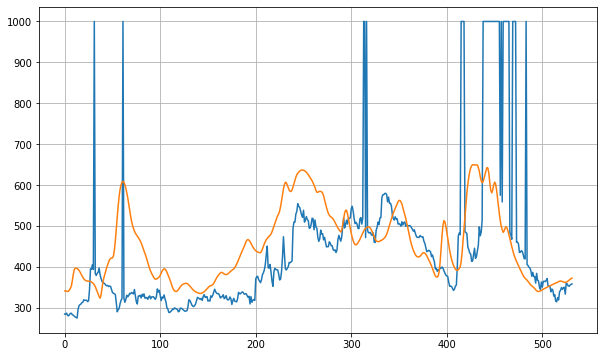

In [53]:
time_steps = [i for i in range(len(predictions))]
plot_series(time_steps, (sp_valid[:len(predictions)], predictions))

In [54]:
print(tf.keras.metrics.mean_absolute_error(sp_valid[:len(predictions)], predictions[:][:,0]).numpy())

102.51801


In [37]:
model.save('speed_using_field.h5')